<h1 align="center">PART III</h1>
<h1 align="center">Training and Development of Different LSTM Models</h1> 

To get started, let's download the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h2 align="center">Preparation of input data</h2> 

Firstly, we will load the sample data we processed in the first part:

In [3]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [4]:
print("Number of documents:", len(docs))

Number of documents: 38544


Now we will load our word2vec model. 

This may take some time, as the model contains 400 000 words, so we will get a 400 000 x 50 embedding matrix that contains all the values of the word vectors.

In [5]:
model = word2vec.KeyedVectors.load_word2vec_format('model/glove.6B.50d.w2vformat.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [6]:
words = list(model.vocab)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [7]:
print("Total words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

Total words: 400000 

Word-Vectors shape: (400000, 50)


The shape of our sample for training will be `(H, N, 50)`, where:
* `H` - number of samples;
* `N` - number of words in each sentence;
* `50` - dimension of each word.

Let's analyze how many words are usually found in the reviews:

In [8]:
max_word, min_word = 0, 100
word50, word100, word200, word300, word400  = 0, 0, 0, 0, 0
reviews_len = []

for review, state in docs:
    reviews_len.append(len(review))

    if len(review) > max_word: max_word = len(review)
    if len(review) < min_word: min_word = len(review)

    if len(review) > 50: word50 += 1
    if len(review) > 100: word100 += 1
    if len(review) > 200: word200 += 1
    if len(review) > 300: word300 += 1
    if len(review) > 400: word400 += 1
    
print("Average number of words in the review:", int(sum(reviews_len)/len(reviews_len)))
print("\nMaximum review length:", max_word, "\nMinimum review length:", min_word)
print("\nReview with more than 50 words:", word50, 
      "\nReview with more than 100 words:", word100,
      "\nReview with more than 200 words:", word200, 
      "\nReview with more than 300 words:", word300,
      "\nReview with more than 400 words:", word400)

Average number of words in the review: 46

Maximum review length: 2376 
Minimum review length: 1

Review with more than 50 words: 10668 
Review with more than 100 words: 3667 
Review with more than 200 words: 893 
Review with more than 300 words: 304 
Review with more than 400 words: 126


Visualize the frequency of words in the review:

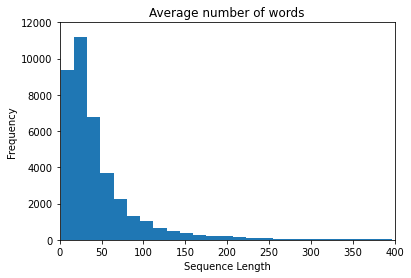

In [9]:
plt.hist(reviews_len, bins=150)
plt.axis([0, 400, 0, 12000])
plt.ylabel('Frequency')
plt.xlabel('Sequence Length');
plt.title("Average number of words");

Our next function `fix_review_len()` will do a useful job, this function is designed to fix the size of reviews to a fixed size to feed them into a neural network with reviews of a certain length. Reviews whose length is less than fixed will be extended by zeros. This process does not affect the algorithm and reviews longer than the specified length will be truncated.

In [10]:
def fix_review_len(review, length):
    if len(review) > length:
        review = review[:length]
    elif len(review) < length:
        for i in range(length - len(review)):
            zeros = [0] * 50
            review.append(zeros)
    return review

example = [3, 1, 2, 4, 5]
example = fix_review_len(example, 7)
print(example) 

[3, 1, 2, 4, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


Now let's slightly improve our `sent_embed()` function from previous part and then update our dataset with word vectors.

Based on the histogram data, as well as the average number of words in the files, we can say with confidence that most reviews will have less than 100 words, which is the maximum value of the length of the sequence that we set.

In [11]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], [] 
    
    max_seq_len = 100
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence, state - state of the sentence (pos/neg)
    for sent, state in docs:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                sent_embed.append([0] * 50)
        
        # add a sentence vector to the list
        sent_embed = fix_review_len(sent_embed, max_seq_len)
        x_sent_embed.append(sent_embed)
        
        # add a label to y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    return x_sent_embed, y_sent_embed

In [12]:
x, y = sent_embed(words, docs)

In [ ]:
x = np.array(x)
print("Shape of X:", x.shape)

<h3 align="center">Split Corpus</h3>

Now, for further work, we will divide our corpus for training, testing and development sets:

In [ ]:
from sklearn.model_selection import train_test_split

# train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

# train dev
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [ ]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

In [ ]:
print("Shape of x_train set:", x_train.shape)